In [67]:
# Standard Library Imports
from itertools import combinations

# Third-party Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
    mean_absolute_error as mae
)
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Local Imports
from modules import forecast

# IPython Magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read SCM data

In [89]:
# contains selected ERA-features, as identified in 3_train_model.ipynb
era = pd.read_csv("data/features/era_features_and_target_v4.csv")

# contains bias-adjusted monthly tmean and rainfall data for each model and init_month
nmme = pd.read_csv("nmme/data/features/bias_adjusted_nmme_features_v2.csv")
clik = pd.read_csv("clik-apcc/data/features/bias_adjusted_clik_features_v2.csv")
c3s = pd.read_csv("c3s/data/features/bias_adjusted_c3s_features_v2.csv")

scm = pd.concat([nmme, clik, c3s], ignore_index=True).drop_duplicates()
# create testset (temporary)
scm = scm.loc[(scm["model"].isin(["ERA", "ECMWF"])) & (scm["year"].between(2001, 2004)), ["model", "year", "init_month", "tmean_bahia blanca_9", "rain_bahia blanca_9"]].reset_index(drop=True)
scm

,model,year,init_month,tmean_bahia blanca_9,rain_bahia blanca_9
0,ERA,2001,12,11.084945,0.002972
1,ERA,2002,12,11.424951,0.001431
2,ERA,2003,12,12.914779,0.001230
3,ERA,2004,12,12.456608,0.001855
4,ECMWF,2001,9,11.997385,0.001036
5,ECMWF,2001,10,11.084945,0.002972
6,ECMWF,2001,11,11.084945,0.002972
7,ECMWF,2002,9,12.197358,0.002374
8,ECMWF,2002,10,11.424951,0.001431
9,ECMWF,2002,11,11.424951,0.001431


### 2. Expand features through basis functions

In [150]:
def apply_basis_expansion(data):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with tmean_squared, rain_squared, and tmean_times_rain features
    """ 
    filtered_data = data.loc[data["year"] < 2017].reset_index(drop=True)
    standardized_data = []
    for year in filtered_data["year"].unique().tolist():
        # split data
        X_train = filtered_data.loc[filtered_data["year"] != year, [c for c in filtered_data.columns if ("rain" in c) or ("tmean" in c)]].reset_index(drop=True)
        X_val = filtered_data.loc[(filtered_data["year"] == year) & (filtered_data["model"] != "ERA"), [c for c in filtered_data.columns if ("rain" in c) or ("tmean" in c)]].reset_index(drop=True)
        y_val = filtered_data.loc[(filtered_data["year"] == year) & (filtered_data["model"] != "ERA"), [c for c in filtered_data.columns if ("rain" not in c) and ("tmean" not in c)]].reset_index(drop=True)
        X_columns = X_val.columns
        
        scaler = StandardScaler()
        X_val_standardized = (X_val - X_train.mean()) / X_train.std()
        #X_val_standardized = scaler.fit(X_train).transform(X_val)
        #print(year)
        #print(X_train)
        #print(X_val_standardized**2)
        #print(len(X_val_standardized.flatten()))
        #X_val_standardized = pd.DataFrame(X_val_standardized, columns=X_columns)
        standardized_df = pd.concat([y_val, X_val_standardized], axis=1)
        standardized_data.append(standardized_df)
    
    df_standardized = pd.concat(standardized_data, ignore_index=True)
    X = df_standardized.loc[:, [c for c in df_standardized.columns if ("rain" in c) or ("tmean" in c)]].reset_index(drop=True)
    y = df_standardized.loc[:, [c for c in df_standardized.columns if ("rain" not in c) and ("tmean" not in c)]].reset_index(drop=True)
    X_columns = X.columns
    # store features and target in variables for better readability
    X_temp = X.loc[:, [c for c in X.columns if ("tmean" in c)]]
    X_rain = X.loc[:, [c for c in X.columns if ("rain" in c)]]

    # basis expansion to linear model
    X_tmean_squared = X_temp.mul(X_temp)
    X_rain_squared = X_rain.mul(X_rain)
    X_rain_tmean = X_rain * X_temp.values
    X_tmean_squared.columns = ["tmean_squared_{}".format("_".join(c.split("_")[1:])) for c in X_tmean_squared.columns]
    X_rain_squared.columns = ["rain_squared_{}".format("_".join(c.split("_")[1:])) for c in X_rain_squared.columns]
    X_rain_tmean.columns = ["tmean_rain_{}".format("_".join(c.split("_")[1:])) for c in X_rain_tmean.columns]
    
    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_rain_tmean, left_index=True, right_index=True), left_index=True, right_index=True))
    data_expanded = pd.concat([y, X], axis=1)
    
    return data_expanded

In [153]:
climate_models = [c for c in scm.model.unique().tolist() if c != "ERA"]
init_months = [9]
li = []
for model in climate_models:
    for month in init_months:
        filtered_scm = scm.loc[(scm["model"].isin([model, "ERA"])) & (scm["init_month"].isin([month, 12]))].reset_index(drop=True)
        filtered_scm_basis_expansion = apply_basis_expansion(filtered_scm)
        li.append(filtered_scm_basis_expansion)
relevant_columns = [c for c in era.columns if c not in ['yield [kg/ha]', 'yield anomaly [%]']]
scm_basis_expansion = pd.concat(li, ignore_index=True).drop_duplicates()
#scm_basis_expansion = pd.concat(li, ignore_index=True).drop_duplicates()[relevant_columns]

   tmean_bahia blanca_9
0             -0.721819
1             -0.184579
2              2.015810
3              0.426929
   rain_bahia blanca_9
0            -1.022109
1             0.522405
2            -1.304423
3             1.784094


In [154]:
scm.loc[(scm["init_month"].isin([9, 12])), ["model", "year", "tmean_bahia blanca_9"]]

,model,year,tmean_bahia blanca_9
0,ERA,2001,11.084945
1,ERA,2002,11.424951
2,ERA,2003,12.914779
3,ERA,2004,12.456608
4,ECMWF,2001,11.997385
7,ECMWF,2002,12.197358
10,ECMWF,2003,13.074427
13,ECMWF,2004,12.452776


In [156]:
avg = scm.loc[(scm["init_month"].isin([9, 12])) & (scm["year"] != 2001) , ["tmean_bahia blanca_9"]].mean().values[0]
std = scm.loc[(scm["init_month"].isin([9, 12])) & (scm["year"] != 2001) , ["tmean_bahia blanca_9"]].std().values[0]

print(((11.997385 - avg) / std))

-0.7218188129445521


In [157]:
scm_basis_expansion.loc[scm_basis_expansion["init_month"] == 9, ["model", "year", "init_month", "tmean_rain_bahia blanca_9"]]

,model,year,init_month,tmean_rain_bahia blanca_9
0,ECMWF,2001,9,0.737778
1,ECMWF,2002,9,-0.096425
2,ECMWF,2003,9,-2.629468
3,ECMWF,2004,9,0.761682


In [7]:
scm_basis_expansion.loc[(scm_basis_expansion["model"].isin(["NCEP", "DWD"])) & (scm_basis_expansion["year"] == 1993), ["model", "year", "init_month", "rain_squared_hipolito yrigoyen_9"]]

,model,year,init_month,rain_squared_hipolito yrigoyen_9
216,NCEP,1993,9,0.231268
240,NCEP,1993,10,0.256655
264,NCEP,1993,11,0.256655
720,DWD,1993,9,0.241714
744,DWD,1993,10,0.256655
768,DWD,1993,11,0.256655


Bring ERA features and SCM features together and include yield target column

In [8]:
scm_basis_expansion = scm_basis_expansion.merge(era[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")

# features, target, metadata
x_y_cv = pd.concat([era, scm_basis_expansion], ignore_index=True).drop_duplicates()

# for faster easier access of features
relevant_columns = [c for c in x_y_cv.columns if ("rain" in c) or ("tmean" in c)]

### 3. Identify SCM that are capable of forecasting features

We only consider models that are able to forecast any feature better than climatology, represented with a R2 of > 0.
If we don't do this, forecast skill will be abitrary and not based on SCM skill to forecast features.

In [9]:
climate_models = [c for c in scm.model.unique().tolist() if c != "ERA"]
good_models = []
init_months = [9, 10, 11]
for model in climate_models:
    for month in init_months:
        # exclude e.g. tmean_9 for init_month 10
        future_features = [c for c in relevant_columns if int(c.split("_")[-1]) >= month]
        for col in future_features:
            predicted = x_y_cv.loc[(x_y_cv["model"] == model) & (x_y_cv["init_month"] == month), col].reset_index(drop=True)
            observed = x_y_cv.loc[(x_y_cv["model"] == "ERA") & (x_y_cv["init_month"] == 12), col].reset_index(drop=True)
            current_r2 = np.round(r2_score(observed, predicted),2)
            if current_r2 > 0:
                good_models.append(model)
                print("R\u00b2: {}; {}; init_mont: {}; feature: {}".format(current_r2, model, month, col))
good_models = list(set(good_models))

R²: 0.13; GFDL; init_mont: 9; feature: tmean_rain_bahia blanca_9
R²: 0.12; GFDL; init_mont: 10; feature: tmean_squared_bahia blanca_11
R²: 0.18; GFDL; init_mont: 10; feature: tmean_squared_santa fe san justo_11
R²: 0.01; GFDL; init_mont: 11; feature: tmean_rain_santa fe san justo_11
R²: 0.02; NASA; init_mont: 11; feature: tmean_rain_santa fe san justo_11
R²: 0.08; NASA; init_mont: 11; feature: tmean_squared_bahia blanca_11
R²: 0.23; NASA; init_mont: 11; feature: tmean_squared_santa fe san justo_11
R²: 0.19; NCEP; init_mont: 11; feature: tmean_squared_bahia blanca_11
R²: 0.17; NCEP; init_mont: 11; feature: tmean_squared_santa fe san justo_11
R²: 0.52; BOM; init_mont: 11; feature: tmean_squared_santa fe san justo_11
R²: 0.01; CWB; init_mont: 10; feature: tmean_rain_santa fe san justo_11
R²: 0.23; CWB; init_mont: 10; feature: tmean_squared_bahia blanca_11
R²: 0.2; CWB; init_mont: 10; feature: tmean_squared_santa fe san justo_11
R²: 0.11; CWB; init_mont: 11; feature: tmean_squared_bahia bl

In [11]:
good_models

['ECCC', 'ECMWF', 'GFDL', 'JMA', 'NASA', 'CWB', 'BOM', 'METFR', 'KMA', 'NCEP']

We filter the good models

In [12]:
x_y_cv_filtered = x_y_cv.loc[x_y_cv["model"].isin(good_models + ["ERA"])].reset_index(drop=True)
x_y_cv_filtered.head()

,model,year,init_month,yield [kg/ha],yield anomaly [%],tmean_rain_santa fe san justo_11,rain_squared_hipolito yrigoyen_9,tmean_rain_santa fe san justo_10,tmean_squared_bahia blanca_11,tmean_rain_bahia blanca_9,rain_squared_santa fe san justo_11,tmean_squared_santa fe san justo_11,tmean_rain_bahia blanca_11,tmean_rain_hipolito yrigoyen_11
0,ERA,1993,12,2037.439151,-0.046171,-1.767627,0.256655,-2.176832,2.153812,-0.101273,1.226205,2.548110,-1.297937,-1.595325
1,ERA,1994,12,2185.741998,0.018138,0.308643,0.235756,-1.051838,1.842640,-0.422610,0.235401,0.404675,-1.490589,-0.691174
2,ERA,1995,12,1946.759707,-0.102265,-0.257157,0.793068,0.135663,0.017397,-1.151954,0.055487,1.191816,0.020478,0.235230
3,ERA,1996,12,2260.470320,0.040968,0.248492,0.725714,-0.040851,0.513886,-0.049864,0.228297,0.270474,0.678951,-0.078975
4,ERA,1997,12,2623.252920,0.175913,-0.006841,0.374834,0.014751,1.072271,0.027622,0.029486,0.001587,0.921794,-0.711850


### 4. Train model

In [13]:
models = good_models 
results_r2 = pd.DataFrame(0, index=models, columns=[9, 10, 11])
results_rmse = pd.DataFrame(0, index=models, columns=[9, 10, 11])
for im in [9, 10, 11, 12]:
    for model in models:
        res, _ = forecast.kfold_cross_validation(x_y_cv_filtered, model=model, init=im, augment=False, no_of_features=6)
        # rmse
        metric = 100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False)
        results_rmse.loc[model, im] = np.round(metric, 2)
        # r
        #metric = np.round(pearsonr(res["predicted"], res["yield anomaly [%]"])[0], 2)
        # coefficient of determination
        metric = r2_score(res["yield anomaly [%]"], res["predicted"])
        results_r2.loc[model, im] = np.round(metric, 2)

#### Create figure

In [14]:
results_r2 = results_r2.transpose().stack().reset_index().rename(columns={"level_0":"init_month", "level_1":"model", 0:"R2"})
results_rmse = results_rmse.transpose().stack().reset_index().rename(columns={"level_0":"init_month", "level_1":"model", 0:"RRMSE [%]"})

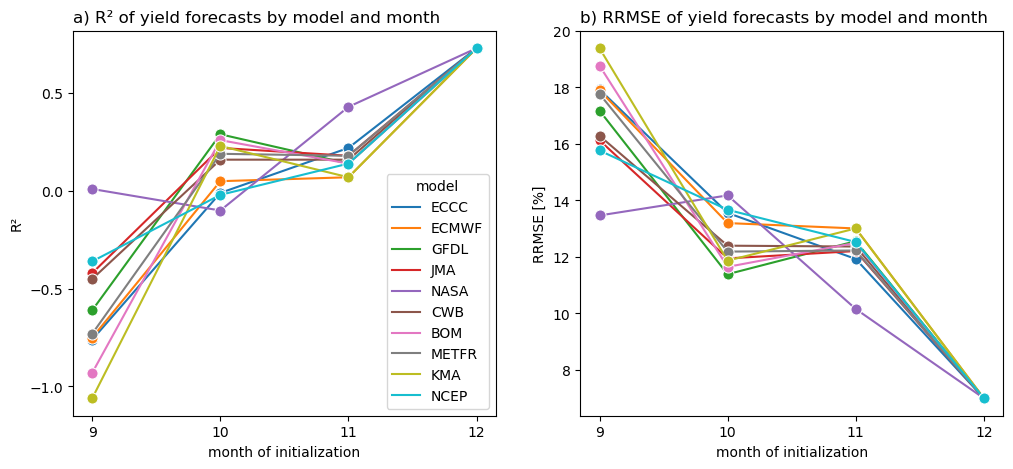

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs = axs.ravel()
sns.lineplot(results_r2, x="init_month", y="R2", hue="model", marker="o", markersize=8, ax=axs[0])
axs[0].set_xlabel("month of initialization");
axs[0].set_title("a) R\u00b2 of yield forecasts by model and month", loc="left")
axs[0].set_ylabel("R\u00b2");
axs[0].set_xticks([9, 10, 11, 12]);
axs[0].set_yticks([-1, -0.5, 0, 0.5])
#plt.savefig("r2_model_init_month.svg");

sns.lineplot(results_rmse, x="init_month", y="RRMSE [%]", hue="model", marker="o", markersize=8, ax=axs[1])
axs[1].set_xlabel("month of initialization");
axs[1].set_title("b) RRMSE of yield forecasts by model and month", loc="left")
axs[1].set_ylabel("RRMSE [%]");
axs[1].set_xticks([9, 10, 11, 12]);
axs[1].get_legend().remove()
#axs[1].set_yticks([-1, -0.5, 0, 0.5])
plt.savefig("r2_rmse_model_init_month.svg");
plt.show();


#### Using the R2 metric, we identify that forecast in September are not skillful (R2 < 0). Hence from now on, we will base our analysis on forecasts made in Oktober.

In [17]:
x_y_cv_filtered = x_y_cv_filtered.loc[x_y_cv_filtered["init_month"].isin([10, 12])].reset_index(drop=True)

#### 3.5 MME

Come up with a weighted average scheme

1. Iterate over each SCM and calculate error to ERA-features and safe in dict

In [147]:
climate_models = good_models
model_to_feature_to_r2 = {}
for model in climate_models:
    model_to_feature_to_r2[model] = {}
    # exclude e.g. tmean_9 for init_month 10
    future_features = [c for c in relevant_columns if int(c.split("_")[-1]) >= 10]
    for col in future_features:
        model_to_feature_to_r2[model][col] = {}
        for year in list(range(1993, 2017)):
            predicted = x_y_cv_filtered.loc[(x_y_cv_filtered["model"] == model) & (x_y_cv_filtered["init_month"] == 10) & (x_y_cv_filtered["year"] != year), col].reset_index(drop=True)
            observed = x_y_cv_filtered.loc[(x_y_cv_filtered["model"] == "ERA") & (x_y_cv_filtered["init_month"] == 12) & (x_y_cv_filtered["year"] != year), col].reset_index(drop=True)
            current_r2 = np.round(r2_score(observed, predicted), 4)
            if current_r2 < 0: current_r2 = 0
            model_to_feature_to_r2[model][col][year] = current_r2

2. bring dict into shape to be merged with x_y_cv

In [155]:
df = pd.DataFrame.from_dict(model_to_feature_to_r2, orient="index")
li=[]
for col in [c for c in relevant_columns if int(c.split("_")[-1]) >= 10]:
    li.append(df[col].apply(pd.Series).stack().reset_index().rename(columns={"level_0":"model", "level_1":"year", 0:"R2_feature"}).assign(feature=col))
df = pd.concat(li, ignore_index=True)
df = df.pivot(index=["model", "year"], columns="feature", values="R2_feature")
df.columns = ["R2_"+c for c in df.columns]
weight_df = df.reset_index()
weight_df.head()

,model,year,R2_rain_squared_santa fe san justo_11,R2_tmean_rain_bahia blanca_11,R2_tmean_rain_hipolito yrigoyen_11,R2_tmean_rain_santa fe san justo_10,R2_tmean_rain_santa fe san justo_11,R2_tmean_squared_bahia blanca_11,R2_tmean_squared_santa fe san justo_11
0,BOM,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BOM,1994,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BOM,1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BOM,1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BOM,1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3. Calculate climatology LOYO for each feature

In [156]:
col_to_year_to_climatology = {}
for col in relevant_columns:
    col_to_year_to_climatology[col] = {}
    for year in list(range(1993, 2017)):
        val = x_y_cv_filtered.loc[(x_y_cv_filtered["model"] == "ERA") & (x_y_cv_filtered["year"] != year), col].mean()
        col_to_year_to_climatology[col][year] = val

4. merge with dataframe and replace values

In [159]:
x_y_cv_mme = x_y_cv_filtered.merge(df, on=["model", "year"], how="left")

mme_models = ["ECMWF", "METFR"]
for col in [c for c in relevant_columns if int(c.split("_")[-1]) >= 10]:
    subset = x_y_cv_mme.loc[x_y_cv_mme["model"].isin(mme_models), col]
    print(subset)
    

192    0.004846
193    0.217457
194   -0.726335
195   -0.690326
196   -4.345869
197   -0.028930
198    0.395732
199   -0.818296
200    0.528528
201    0.277022
202   -0.008421
203   -0.131031
204   -0.286264
205    0.046838
206    1.516405
207   -2.587768
208    1.785363
209   -0.515722
210   -0.712784
211   -0.010147
212    0.934850
213   -0.249556
214   -2.835369
215   -0.046988
240   -0.126196
241    0.218961
242   -0.235685
243   -1.002550
244   -2.819996
245    0.273617
246    0.019469
247    0.049934
248   -2.451525
249   -0.085231
250   -3.689037
251    0.063734
252    0.058176
253   -0.107674
254    0.408565
255   -0.621521
256    0.185994
257   -1.667013
258    0.100303
259   -1.426983
260   -0.612019
261   -0.355247
262    0.187227
263    0.079576
Name: tmean_rain_santa fe san justo_11, dtype: float64
192   -2.318346
193   -0.081173
194   -0.824160
195   -0.801393
196   -0.905085
197   -0.287708
198    0.696934
199   -0.370983
200   -0.005502
201    0.092639
202   -0.340059
2

,model,year,init_month,yield [kg/ha],yield anomaly [%],tmean_rain_santa fe san justo_11,rain_squared_hipolito yrigoyen_9,tmean_rain_santa fe san justo_10,tmean_squared_bahia blanca_11,tmean_rain_bahia blanca_9,...,tmean_squared_santa fe san justo_11,tmean_rain_bahia blanca_11,tmean_rain_hipolito yrigoyen_11,R2_rain_squared_santa fe san justo_11,R2_tmean_rain_bahia blanca_11,R2_tmean_rain_hipolito yrigoyen_11,R2_tmean_rain_santa fe san justo_10,R2_tmean_rain_santa fe san justo_11,R2_tmean_squared_bahia blanca_11,R2_tmean_squared_santa fe san justo_11
0,ERA,1993,12,2037.439151,-0.046171,-1.767627,0.256655,-2.176832,2.153812,-0.101273,...,2.548110,-1.297937,-1.595325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ERA,1994,12,2185.741998,0.018138,0.308643,0.235756,-1.051838,1.842640,-0.422610,...,0.404675,-1.490589,-0.691174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ERA,1995,12,1946.759707,-0.102265,-0.257157,0.793068,0.135663,0.017397,-1.151954,...,1.191816,0.020478,0.235230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ERA,1996,12,2260.470320,0.040968,0.248492,0.725714,-0.040851,0.513886,-0.049864,...,0.270474,0.678951,-0.078975,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ERA,1997,12,2623.252920,0.175913,-0.006841,0.374834,0.014751,1.072271,0.027622,...,0.001587,0.921794,-0.711850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,METFR,2012,10,2958.105831,-0.077628,-1.426983,0.465787,-0.044969,1.070880,-1.346282,...,0.479035,-2.920782,-3.278127,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,METFR,2013,10,2707.197487,-0.161119,-0.612019,0.201314,-0.087121,1.592317,-1.963790,...,1.458232,0.924978,-0.384119,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261,METFR,2014,10,2892.845436,-0.093509,-0.355247,0.263511,0.257641,0.246985,-0.970486,...,0.492209,-0.443590,-0.190151,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262,METFR,2015,10,3101.367972,-0.032409,0.187227,0.532778,0.557111,0.716162,0.805766,...,0.468093,0.066355,0.048581,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
mme = x_y_cv_filtered.loc[x_y_cv_filtered["model"].isin(combi)].assign(model="MME_{}".format("_".join(combi))).groupby(["model", "year", "init_month"]).mean().reset_index()
x_y_cv_mme = pd.concat([mme, x_y_cv_filtered], ignore_index=True)
res, _ = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(combi)), init=10, augment=augment_model, no_of_features=6)

In [19]:
relevant_models = good_models
mme_size_to_results = {}
for size in range(1,11):
    mme_size_to_results[size] = []
    model_combinations = list(combinations([c for c in relevant_models if c != "ERA"], size))
    print(len(model_combinations))
    if size == 1: augment_model = True
    else: augment_model = False
    #running_sum = 0
    for i in range(0, len(model_combinations)):
        combi = list(model_combinations[i])
        mme = x_y_cv_filtered.loc[x_y_cv_filtered["model"].isin(combi)].assign(model="MME_{}".format("_".join(combi))).groupby(["model", "year", "init_month"]).mean().reset_index()
        x_y_cv_mme = pd.concat([mme, x_y_cv_filtered], ignore_index=True)
        res, _ = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(combi)), init=10, augment=False, no_of_features=6)
        #metric = pearsonr(res["yield anomaly [%]"], res["predicted"])[0]
        metric = r2_score(res["yield anomaly [%]"], res["predicted"])
        #running_sum += metric
        mme_size_to_results[size].append(np.round(metric, 4))
        if metric > 0.4:
            print("R2 is {} for {}".format(np.round(metric, 3), "_".join(combi)))
    #mme_size_to_results[size] = np.round(running_sum / len(model_combinations), 4)
    print(mme_size_to_results)
    

10
{1: [-0.0063, 0.0469, 0.2892, 0.2182, -0.1006, 0.1578, 0.2565, 0.1865, 0.2291, -0.0227]}
45
R2 is 0.431 for GFDL_CWB
R2 is 0.468 for GFDL_BOM
R2 is 0.429 for GFDL_KMA
{1: [-0.0063, 0.0469, 0.2892, 0.2182, -0.1006, 0.1578, 0.2565, 0.1865, 0.2291, -0.0227], 2: [0.0647, 0.3868, 0.2319, 0.0061, 0.1612, 0.2569, 0.2589, 0.271, 0.124, 0.3657, 0.2455, 0.0333, 0.1544, 0.284, 0.2504, 0.2641, 0.1184, 0.3446, 0.2832, 0.4308, 0.4682, 0.3589, 0.4288, 0.2995, 0.172, 0.3327, 0.3945, 0.3278, 0.3639, 0.3, 0.1401, 0.2018, 0.1501, 0.1733, 0.0545, 0.3557, 0.3352, 0.3471, 0.1795, 0.394, 0.3962, 0.2472, 0.2884, 0.2428, 0.2837]}
120
R2 is 0.434 for ECCC_GFDL_BOM
R2 is 0.426 for ECCC_GFDL_KMA
R2 is 0.431 for ECMWF_GFDL_BOM
R2 is 0.408 for ECMWF_GFDL_KMA
R2 is 0.419 for GFDL_JMA_CWB
R2 is 0.452 for GFDL_JMA_BOM
R2 is 0.424 for GFDL_JMA_KMA
R2 is 0.479 for GFDL_CWB_BOM
R2 is 0.43 for GFDL_CWB_METFR
R2 is 0.461 for GFDL_CWB_KMA
R2 is 0.461 for GFDL_BOM_METFR
R2 is 0.489 for GFDL_BOM_KMA
R2 is 0.411 for JMA_CWB

In [20]:
mme_size_to_results_df = pd.DataFrame.from_dict(mme_size_to_results, orient='index').transpose()

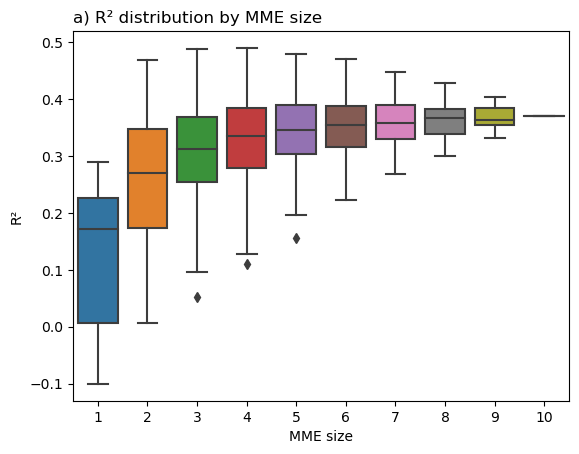

In [46]:
sns.boxplot(mme_size_to_results_df)
plt.title("a) R\u00b2 distribution by MME size", loc="left")
plt.xlabel("MME size")
plt.ylabel("R\u00b2")
plt.savefig("r2_by_mme_size.svg");
plt.show();

In [22]:
df_no_era = x_y_cv_filtered.loc[(x_y_cv_filtered["init_month"] == 10) & (x_y_cv_filtered["model"] != "ERA"), ['model', 'year', 'init_month'] + relevant_columns].reset_index(drop=True)
df_era = x_y_cv_filtered.loc[(x_y_cv_filtered["init_month"] == 12) & (x_y_cv_filtered["model"] == "ERA"), ['model', 'year', 'init_month'] + relevant_columns].reset_index(drop=True)
N = len(df_no_era["model"].unique().tolist())
model_to_error = {}

# calculate bias between each model and ERA
corr_matrices = []
for col in relevant_columns:
    model_to_error[col] = {}
    for model in relevant_models:
        bias = np.array(df_no_era.loc[df_no_era["model"] == model, col]) - np.array(df_era.loc[df_era["model"] == "ERA", col])
        model_to_error[col][model] = bias.flatten()
    df = pd.DataFrame(model_to_error[col])
    correlation_matrix = df.corr()
    corr_matrices.append(correlation_matrix)

correlation_matrix = sum(corr_matrices) / len(corr_matrices)
correlation_matrix


,ECCC,ECMWF,GFDL,JMA,NASA,CWB,BOM,METFR,KMA,NCEP
ECCC,1.000000,0.759513,0.597570,0.677072,0.776993,0.801494,0.647882,0.580791,0.617841,0.707607
ECMWF,0.759513,1.000000,0.571632,0.746020,0.727224,0.791582,0.764647,0.687342,0.646611,0.833247
GFDL,0.597570,0.571632,1.000000,0.625683,0.663638,0.674369,0.533879,0.657740,0.573497,0.711072
JMA,0.677072,0.746020,0.625683,1.000000,0.680999,0.646170,0.699529,0.670142,0.651347,0.697959
NASA,0.776993,0.727224,0.663638,0.680999,1.000000,0.749780,0.658891,0.693653,0.672606,0.758618
CWB,0.801494,0.791582,0.674369,0.646170,0.749780,1.000000,0.663234,0.637103,0.660079,0.770847
BOM,0.647882,0.764647,0.533879,0.699529,0.658891,0.663234,1.000000,0.651531,0.671617,0.750265
METFR,0.580791,0.687342,0.657740,0.670142,0.693653,0.637103,0.651531,1.000000,0.587890,0.718508
KMA,0.617841,0.646611,0.573497,0.651347,0.672606,0.660079,0.671617,0.587890,1.000000,0.668894
NCEP,0.707607,0.833247,0.711072,0.697959,0.758618,0.770847,0.750265,0.718508,0.668894,1.000000


In [54]:
metrics = []
correlations = []
sizes = []
models_mme = []
for size in range(2,5):
    model_combinations = list(combinations([c for c in relevant_models if c != "ERA"], size))
    print(len(model_combinations))
    for i in range(0, len(model_combinations)):
        combi = list(model_combinations[i])
        mme = x_y_cv_filtered.loc[x_y_cv_filtered["model"].isin(combi)].assign(model="MME_{}".format("_".join(combi))).groupby(["model", "year", "init_month"]).mean().reset_index()
        x_y_cv_mme = pd.concat([mme, x_y_cv_filtered], ignore_index=True)
        res, _ = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(combi)), init=10, no_of_features=6)
        #metric = pearsonr(res["yield anomaly [%]"], res["predicted"])[0]
        metric = r2_score(res["yield anomaly [%]"], res["predicted"])
        sizes.append(size)
        models_mme.append("_".join(combi))
        metrics.append(metric)
        corr = correlation_matrix.loc[correlation_matrix.index.isin(combi), combi].where(np.triu(np.ones(len(combi)), k=1).astype(bool)).stack().mean()
        correlations.append(corr)
    

45
120
210


In [52]:
metrics_to_correlation = pd.DataFrame(
    {'metrics': metrics,
     'MME size': sizes,
     'correlation': correlations,
     'models': models_mme
    })
metrics_to_correlation.head()

,metrics,MME size,correlation,models
0,0.064719,2,0.759513,ECCCECMWF
1,0.386812,2,0.597570,ECCCGFDL
2,0.231898,2,0.677072,ECCCJMA
3,0.006061,2,0.776993,ECCCNASA
4,0.161219,2,0.801494,ECCCCWB


In [55]:
metrics_to_correlation.sort_values(by="metrics", ascending=False).head(10)

,metrics,MME size,correlation,models
331,0.490112,4,0.629446,GFDLCWBBOMKMA
125,0.488683,3,0.592998,GFDLBOMKMA
120,0.479456,3,0.623827,GFDLCWBBOM
315,0.474932,4,0.625925,GFDLJMABOMKMA
330,0.474455,4,0.636309,GFDLCWBBOMMETFR
20,0.468227,2,0.533879,GFDLBOM
310,0.466402,4,0.640477,GFDLJMACWBBOM
336,0.463485,4,0.612692,GFDLBOMMETFRKMA
124,0.461403,3,0.614384,GFDLBOMMETFR
122,0.461147,3,0.635982,GFDLCWBKMA


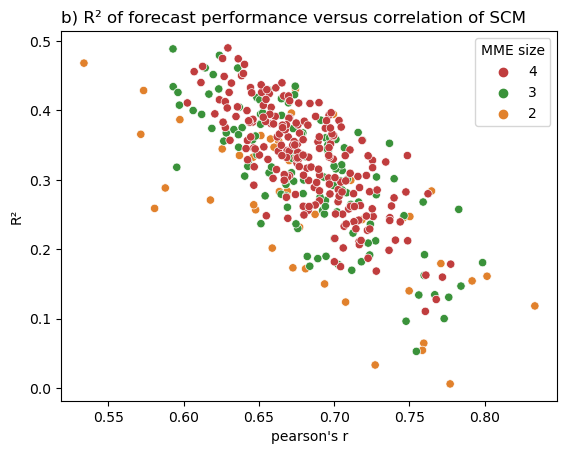

In [49]:
#sns.scatterplot(data=metrics_to_correlation, x="correlation", y="metrics")
sns.scatterplot(x = "correlation", y = "metrics", hue="MME size", data = metrics_to_correlation, palette=["#C03D3E", "#3A923A", "#E1812C"], hue_order=[4, 3, 2])
plt.title("b) R\u00b2 of forecast performance versus correlation of SCM", loc="left")
plt.xlabel("pearson's r")
plt.ylabel("R\u00b2")
plt.savefig("r2_by_correlation.svg");
plt.show();

### 4. Show performance for GFDL, BOM

In [58]:
mme = x_y_cv_filtered.loc[x_y_cv_filtered["model"].isin(["BOM", "GFDL"])].assign(model="MME_{}".format("_".join(["BOM", "GFDL"]))).groupby(["model", "year", "init_month"]).mean().reset_index()
x_y_cv_mme = pd.concat([mme, x_y_cv_filtered], ignore_index=True)
era_ra = x_y_cv_filtered.loc[x_y_cv_filtered["model"] == "ERA"].reset_index(drop=True)

res, _ = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(["BOM", "GFDL"])), init=10, augment=False, no_of_features=6)
res2, _ = forecast.kfold_cross_validation(era_ra, model="ERA", init=10, no_of_features=6)

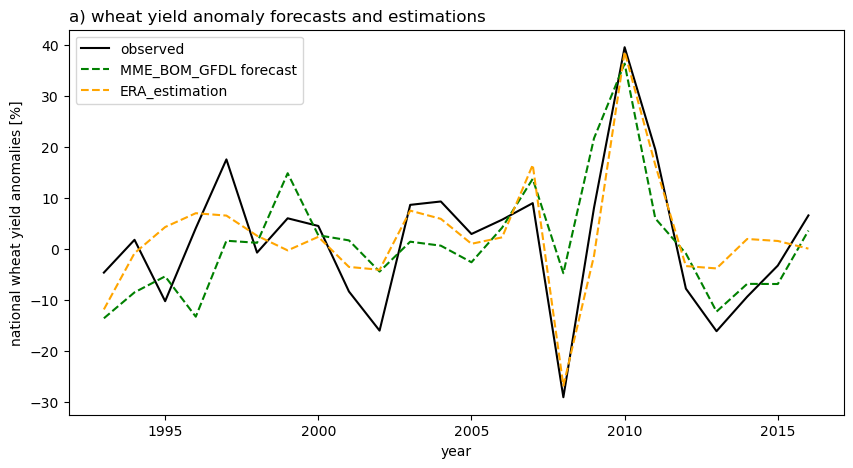

In [63]:
plt.plot(res["year"], 100*res["yield anomaly [%]"], color="black", label="observed");
plt.plot(res["year"], 100*res["predicted"], linestyle="dashed", color="green", label="MME_BOM_GFDL forecast");
plt.plot(res2["year"], 100*res2["predicted"], linestyle="dashed", color="orange", label="ERA_estimation");
plt.ylabel("national wheat yield anomalies [%]")
plt.xlabel("year")
plt.title("a) wheat yield anomaly forecasts and estimations", loc="left")
plt.legend();
fig = plt.gcf()
fig.set_size_inches(10,5)

### 5. explain MME performance for 2010

In [64]:
mme = x_y_cv_filtered.loc[x_y_cv_filtered["model"].isin(["BOM", "GFDL"])].assign(model="MME_{}".format("_".join(["BOM", "GFDL"]))).groupby(["model", "year", "init_month"]).mean().reset_index()
x_y_cv_mme = pd.concat([mme, x_y_cv_filtered], ignore_index=True)
res, year_to_features = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(["BOM", "GFDL"])), init=10, no_of_features=6)
features_2010 = year_to_features[2010].tolist()

<Axes: xlabel='value', ylabel='feature'>

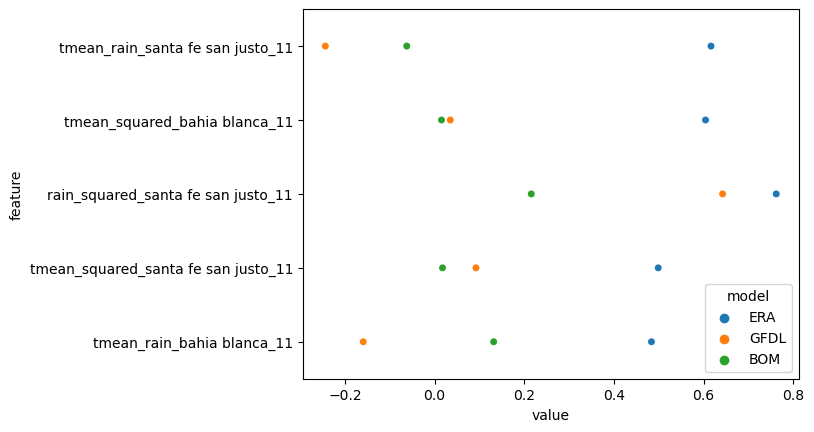

In [66]:
best_mme_df = x_y_cv_filtered.loc[(x_y_cv_filtered["model"].isin(["BOM", "GFDL", "ERA"])) & (x_y_cv_filtered["year"] == 2010) & (x_y_cv_filtered["init_month"].isin([12, 10])), ["model", "year"] + features_2010].reset_index(drop=True)
best_mme_df = best_mme_df.loc[:, [c for c in best_mme_df.columns if ("_9" not in c) and ("year" not in c)]]
best_mme_df = best_mme_df.set_index("model").stack().reset_index().rename(columns={0:"value", "level_1":"feature"})
sns.swarmplot(data=best_mme_df, x="value", y="feature", hue="model", orient="h")